# SMEM Algorithm for Mixture Models
#### Authors: Emeline Laborie & Thomas Bassanetti

---

Project based on the article: 

N. Ueda, R. Nakano, Z. Ghahramani and G. E. Hinton, Split and Merge EM Algorithm for Improving Gaussian Mixture Density Estimates. *The Journal of VLSI Signal Processing*, **26** 133–140 (2000). https://doi.org/10.1023/A:1008155703044

In [1]:
import numpy as np
from numpy.linalg import det, norm, inv
from numpy.random import choice, multivariate_normal, uniform

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.transforms import Affine2D

from scipy.optimize import linear_sum_assignment


## Plots

In [2]:
def plot_ellipse(ax, mean, covariance, n_std):
    """
    Plot the ellipse corresponding to a Gaussian distribution.

    See the following link for a demonstration:
    https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    """

    pearson = covariance[0, 1] / np.sqrt(covariance[0, 0] * covariance[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    mean_x = mean[0]
    mean_y = mean[1]

    scale_x = np.sqrt(covariance[0, 0]) * n_std
    scale_y = np.sqrt(covariance[1, 1]) * n_std

    ellipse = Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor="None", edgecolor="red"
    )

    transf = Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)

    ax.add_patch(ellipse)


def plot_center(ax, mean):
    """Plot the center of the ellipse (mean of the Gaussian)."""
    ax.scatter(*mean, c="red", s=10)


def plot_data_points(data, means, covariances, n_std=3, title=""):
    """Plot the data points and the Gaussian distributions with their means and covariances."""
    fig, ax = plt.subplots()
    ax.scatter(np.array(data[0, :]), np.array(data[1, :]))

    for mean, covariance in zip(means, covariances):
        plot_ellipse(ax, mean, covariance, n_std)
        plot_center(ax, mean)

    ax.axis("equal")
    ax.set_title(title)
    plt.show()


## Data generation

In [3]:
def gen_means(D, N_cluster, L):
    """Generate random means in a box of size L."""
    return [uniform(-L, L, size=D) for _ in range(N_cluster)]


def gen_covariances(D, N_cluster):
    """Generate random covariance matrices."""
    covariances = []
    for _ in range(N_cluster):
        var = np.zeros((D, D))
        for i in range(D):
            var[i, i] = uniform(1, 3)
            for j in range(i + 1, D):
                var[i, j] = uniform(-1, 1)
                var[j, i] = var[i, j]
        covariances.append(var)
    return covariances


def gen_data(N, N_cluster, means, covariances):
    """Generate data matrix with given means and covariances."""
    data_labels = choice(N_cluster, size=N)
    data = np.column_stack(
        [multivariate_normal(means[label], covariances[label]) for label in data_labels]
    )
    return data, data_labels


def generation_data(N, D, N_cluster, L, plot=False, n_std=3):
    """
    Generate random data matrix.
    Can plot the Gaussian distributions used to generate the data.
    """
    means = gen_means(D, N_cluster, L)
    covariances = gen_covariances(D, N_cluster)
    data, data_labels = gen_data(N, N_cluster, means, covariances)

    if plot:
        plot_data_points(data, means, covariances, n_std=n_std, title="True Gaussian distributions")

    return data, data_labels


## EM algorithm

### Initialization step

In [4]:
def initialize_means(data, N_cluster):
    """Initialize means, chosen randomly from the data points."""
    return [data[:, i] for i in choice(data.shape[1], N_cluster, replace=False)]


def initialize_covariances(D, N_cluster):
    """Initialize covariance matrices to identity matrices."""
    return [np.identity(D) for _ in range(N_cluster)]


def initialize_densities(means, data):
    """Initialize densities corresponding to the selected means"""
    N = data.shape[1]
    N_cluster = len(means)

    # Compute distances and find the closest cluster for each data point.
    densities = np.zeros(N_cluster)
    for n in range(N):
        distances = np.array([norm(data[:, n] - mean) for mean in means])
        closest_cluster = np.argmin(distances)
        densities[closest_cluster] += 1

    densities /= N
    return densities


def initialization(data, N_cluster, plot=False, n_std=3):
    """
    Initializes the means, covariances, and densities.
    Optionally plot the Gaussian distributions used to generate the data.
    """
    means = initialize_means(data, N_cluster)
    covariances = initialize_covariances(data.shape[0], N_cluster)
    densities = initialize_densities(means, data)

    if plot:
        plot_data_points(
            data, means, covariances, n_std=n_std, title="Initial Gaussian distributions"
        )

    return means, covariances, densities


### Expectation step

In [5]:
def multivariate_gaussian(X, Mu, Sigma):
    """Compute the probability density of the multivariate Gaussian distribution."""
    d = len(Mu)

    diff = X - Mu
    exponent = -1 / 2 * (diff.T @ inv(Sigma) @ diff).item()
    normalization = np.sqrt((2 * np.pi) ** d * det(Sigma))
    density = np.exp(exponent) / normalization
    return density


In [6]:
def compute_P(data, means, covariances, densities):
    """Compute the probability matrix P where P[n, c] is the probability that data point n belongs to cluster c."""
    N = data.shape[1]
    N_cluster = len(means)

    P = np.zeros((N, N_cluster))
    for c in range(N_cluster):
        P[:, c] = np.array(
            [multivariate_gaussian(data[:, n], means[c], covariances[c]) for n in range(N)]
        )
    P *= densities
    P /= P.sum(axis=1, keepdims=True)

    return P


### Maximization step

In [7]:
def update_means(data, P):
    """ Update the mean vectors for each cluster."""
    N_cluster = P.shape[1]

    means = data @ P / P.sum(axis=0)
    return [means[:, c] for c in range(N_cluster)]


def update_covariances(data, means, P):
    """Update the covariance matrices for each cluster."""
    D, N = data.shape
    N_cluster = len(means)

    covariances = []
    for c in range(N_cluster):
        diff = data - means[c][:, np.newaxis]
        cov = (P[:, c] * diff) @ diff.T
        cov += 1e-10 * np.identity(D)  # Regularization
        cov /= P[:, c].sum()
        covariances.append(cov)
    return covariances


def update_densities(P):
    """Update the prior probabilities (densities) for each cluster."""
    return P.sum(axis=0) / P.shape[0]


def updates(data, P):
    """Update the means, covariances, and densities for each cluster."""
    means = update_means(data, P)
    covariances = update_covariances(data, means, P)
    densities = update_densities(P)
    return means, covariances, densities


### Expectation-maximization algorithm

In [8]:
def compute_log_likelihood(data, means, covariances, densities):
    """Compute the total log likelihood of the data."""
    N = data.shape[1]
    N_cluster = len(means)

    P = np.zeros((N, N_cluster))
    for c in range(N_cluster):
        P[:, c] = [multivariate_gaussian(data[:, n], means[c], covariances[c]) for n in range(N)]
    weighted_P = P * densities
    log_likelihood = np.log(weighted_P.sum(axis=1) + 1e-10).sum()

    return log_likelihood / N


def expectation_maximization(data, means, covariances, densities, eps=1e-3, plot=False, n_std=3):
    """The Expectation-Maximization (EM) algorithm."""
    log_likelihood_before = -np.inf
    log_likelihood_after = compute_log_likelihood(data, means, covariances, densities)
    log_likelihood_fullEM = [log_likelihood_after]

    while log_likelihood_after - log_likelihood_before > eps:
        # E-step: Compute the responsibilities
        P = compute_P(data, means, covariances, densities)

        # M-step: Update the parameters
        means, covariances, densities = updates(data, P)

        # Compute log likelihood
        log_likelihood_before = log_likelihood_after
        log_likelihood_after = compute_log_likelihood(data, means, covariances, densities)
        log_likelihood_fullEM.append(log_likelihood_after)

    if plot:
        plot_data_points(
            data,
            means,
            covariances,
            n_std=n_std,
            title="Gaussian distributions after EM-algorithm",
        )

    return means, covariances, densities, log_likelihood_fullEM


## SMEM algorithm

### Split and Merge criteria

In [9]:
def gaussian_density(data, means, covariances):
    """Compute Gaussian density for each Gaussian and each point."""
    N = data.shape[1]
    N_cluster = len(means)

    gaussians = np.zeros((N_cluster, N))
    for n in range(N):
        for c in range(N_cluster):
            gaussians[c, n] = multivariate_gaussian(data[:, n], means[c], covariances[c])

    return gaussians


def compute_posteriors(data, means, covariances, densities):
    """Compute posterior probabilities for all Gaussian distributions and datapoints."""
    gaussians = gaussian_density(data, means, covariances)
    weighted_gaussians = densities[:, np.newaxis] * gaussians
    P = weighted_gaussians / np.sum(weighted_gaussians, axis=0)
    return P


In [10]:
def merge_criterion(data, means, covariances, densities):
    """
    Determine list of merge candidates (each being a pair of Gaussian distributions)
    sorted from best to worst.
    """
    N_cluster = len(means)

    posteriors = compute_posteriors(data, means, covariances, densities)
    J_merge = np.dot(posteriors, posteriors.T)

    np.fill_diagonal(J_merge, -1)  # Exclude self-pairs by setting the diagonal to -1

    merge_candidates = []
    for _ in range(N_cluster * (N_cluster - 1) // 2):
        i, j = np.unravel_index(np.argmax(J_merge), J_merge.shape)
        merge_candidates.append((i, j))
        J_merge[i, j] = -1  # Mark this pair as used by setting its value to -1

    return merge_candidates


In [11]:
def local_data_density(posteriors):
    """
    Compute local data density for all Gaussian distributions and datapoints.
    See Eq. (19)
    """
    return posteriors / np.sum(posteriors, axis=1, keepdims=True)


def KL_divergence(p, q):
    """
    Kulback-Leibler Divergence of probability distributions p and q.
    It's always strictly positive if p!=q.
    See Eq. (18)
    """
    # Todo: there is a problem here. It needs to be fixed.
    # q /= np.sum(q)  # so that sum(q) = 1 (This may be false)
    # return np.sum(np.where(p > np.finfo(float).eps, p * np.log(p / (q + 1e-10)), 0))
    return np.abs(np.sum(np.where(p > np.finfo(float).eps, p * np.log(p / (q + 1e-10)), 0)))


def split_criterion(data, means, covariances, densities, pair_to_merge):
    """Determine list of split candidates (excluding pair_to_merge) sorted from best to worst."""
    N_cluster = len(means)

    gaussians = gaussian_density(data, means, covariances)
    posteriors = compute_posteriors(data, means, covariances, densities)
    loc_density = local_data_density(posteriors)

    remaining_gaussians = [k for k in range(N_cluster) if k not in pair_to_merge]

    J_split = np.full(N_cluster, -1)
    for k in remaining_gaussians:
        J_split[k] = KL_divergence(loc_density[k, :], gaussians[k, :])

    split_candidates = np.argsort(J_split)[::-1][:len(remaining_gaussians)]
    return split_candidates


In [12]:
def split_merge_criteria(data, means, covariances, densities):
    """
    Determine list of split and merge candidates sorted from best to worst
    See p. 136 §2.
    """
    split_merge_candidates = []

    merge_candidates = merge_criterion(data, means, covariances, densities)
    for i, j in merge_candidates:
        split_candidates = split_criterion(data, means, covariances, densities, (i, j))

        for k in split_candidates:
            split_merge_candidates.append((i, j, k))

    return split_merge_candidates


### Split and Merge i, j ,k

In [13]:
def split_merge_ijk_means(means, densities, i, j, k):
    """Merge i, j and split k for the means."""
    new_means = means.copy()

    # Merge
    new_means[i] = (means[i] * densities[i] + means[j] * densities[j]) / (
            densities[i] + densities[j]
    )

    # Split
    eps = 0.5
    new_mean = means[k]
    new_means[j] = new_mean + uniform(-eps, eps, size=new_mean.shape)
    new_means[k] = new_mean + uniform(-eps, eps, size=new_mean.shape)

    return new_means


def split_merge_ijk_covariances(covariances, densities, i, j, k):
    """Merge i, j and split k for the covariances."""
    new_covariances = covariances.copy()

    # Merge
    new_covariances[i] = (covariances[i] * densities[i] + covariances[j] * densities[j]) / (
            densities[i] + densities[j]
    )

    # Split
    D = len(covariances[0])
    new_covariance = np.power(det(covariances[k]), 1 / D) * np.identity(D)
    new_covariances[j] = new_covariance
    new_covariances[k] = new_covariance

    return new_covariances


def split_merge_ijk_densities(densities, i, j, k):
    """Merge i, j and split k for the densities."""
    new_densities = densities.copy()

    # Merge
    new_densities[i] = densities[i] + densities[j]

    # Split
    new_density = densities[k] / 2
    new_densities[j] = new_density
    new_densities[k] = new_density

    return new_densities


def split_merge_ijk(means, covariances, densities, i, j, k):
    """Merge i, j and split k."""
    means = split_merge_ijk_means(means, densities, i, j, k)
    covariances = split_merge_ijk_covariances(covariances, densities, i, j, k)
    densities = split_merge_ijk_densities(densities, i, j, k)
    return means, covariances, densities


### Split and Merge algorithm (one step)

In [14]:
def compute_P_partial(data, means, covariances, densities, sum_P):
    """Compute posterior probabilities for partial EM procedure."""
    N = data.shape[1]
    P = np.zeros((N, 3))
    for n in range(N):
        for c in range(3):
            g = multivariate_gaussian(data[:, n], means[c], covariances[c])
            P[n, c] = densities[c] * g
        P[n, :] = P[n, :] / np.sum(P[n, :]) * sum_P[n]
    return P


def expectation_maximization_partial(data, i, j, k, new_means, new_covariances, new_densities,
                                     means_ijk, covariances_ijk, densities_ijk, sum_P, eps=1e-3):
    """Partial EM algorithm for updating the parameters of three Gaussian distributions."""
    log_likelihood_before = - np.inf
    new_means, new_covariances, new_densities = new_parameters(
        i, j, k, new_means, new_covariances, new_densities, means_ijk, covariances_ijk, densities_ijk
    )
    log_likelihood_after = compute_log_likelihood(data, new_means, new_covariances, new_densities)
    log_likelihood_partialEM = [log_likelihood_after]

    while log_likelihood_after - log_likelihood_before > eps:
        log_likelihood_before = log_likelihood_after
        P = compute_P_partial(data, means_ijk, covariances_ijk, densities_ijk, sum_P)
        means_ijk, covariances_ijk, densities_ijk = updates(data, P)
        new_means, new_covariances, new_densities = new_parameters(
            i, j, k, new_means, new_covariances, new_densities, means_ijk, covariances_ijk, densities_ijk
        )
        log_likelihood_after = compute_log_likelihood(data, new_means, new_covariances, new_densities)
        log_likelihood_partialEM.append(log_likelihood_after)

    return new_means, new_covariances, new_densities, log_likelihood_partialEM


def new_parameters(
        i, j, k, new_means, new_covariances, new_densities, means_ijk, covariances_ijk, densities_ijk
):
    """Update the parameters of three Gaussian distributions in the full list."""
    new_means[i], new_means[j], new_means[k] = means_ijk
    new_covariances[i], new_covariances[j], new_covariances[k] = covariances_ijk
    new_densities[i], new_densities[j], new_densities[k] = densities_ijk
    return new_means, new_covariances, new_densities


In [15]:
def split_merge_one_step(data, means, covariances, densities, eps, eps_SM):
    """Perform one split and merge step, selecting the best split and merge among candidates."""
    split_merge_candidates = split_merge_criteria(data, means, covariances, densities)
    init_likelihood = compute_log_likelihood(data, means, covariances, densities)
    log_likelihood_list = []
    P = compute_P(data, means, covariances, densities)

    for i, j, k in split_merge_candidates:
        # Initialize parameters of new Gaussian distributions
        new_means, new_covariances, new_densities = split_merge_ijk(means, covariances, densities, i, j, k)

        # List of parameters for the three relevant Gaussian distributions
        means_ijk = [new_means[i], new_means[j], new_means[k]]
        covariances_ijk = [new_covariances[i], new_covariances[j], new_covariances[k]]
        densities_ijk = [new_densities[i], new_densities[j], new_densities[k]]

        # Partial EM procedure on the three new Gaussian distributions
        sum_P = np.sum(P[:, [i, j, k]], axis=1)
        new_means, new_covariances, new_densities, log_likelihood_partialEM = expectation_maximization_partial(
            data, i, j, k, new_means, new_covariances, new_densities,
            means_ijk, covariances_ijk, densities_ijk, sum_P, eps
        )

        # Full EM procedure on all Gaussian distributions
        new_means, new_covariances, new_densities, log_likelihood_fullEM = expectation_maximization(
            data, new_means, new_covariances, new_densities, eps
        )

        # Compute and compare the log-likelihood
        new_likelihood = compute_log_likelihood(data, new_means, new_covariances, new_densities)
        if new_likelihood > init_likelihood + eps_SM:
            log_likelihood_list += log_likelihood_partialEM
            log_likelihood_list += log_likelihood_fullEM
            return True, new_means, new_covariances, new_densities, log_likelihood_list

    return False, means, covariances, densities, log_likelihood_list


### Split and Merge algorithm (full)

In [16]:
def split_merge_full(data, means, covariances, densities, eps_EM=1e-3, eps_SM=1e-3, plot=False):
    """
    Perform the split and merge steps until the improvement in log-likelihood is less than 
    eps_SM or no improvement is possible.
    """
    improvement = True
    count = 0
    log_likelihood_list = []

    while improvement:
        improvement, means, covariances, densities, log_likelihood_one_step = split_merge_one_step(
            data, means, covariances, densities, eps_EM, eps_SM
        )

        if improvement:
            log_likelihood_list.extend(log_likelihood_one_step)
            count += 1
            if plot:
                plot_data_points(
                    data,
                    means,
                    covariances,
                    n_std=3,
                    title=f"Gaussian distributions after {count} SMEM-steps"
                )

    return means, covariances, densities, log_likelihood_list


## Test

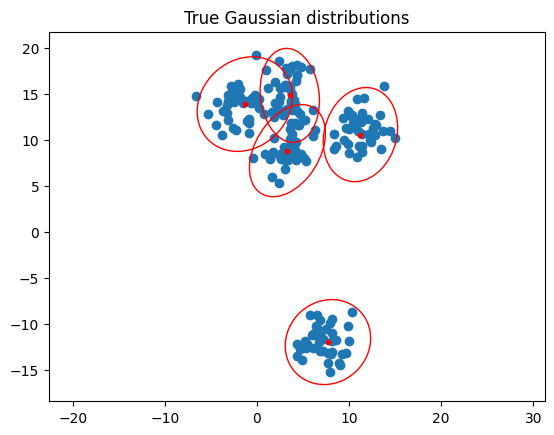

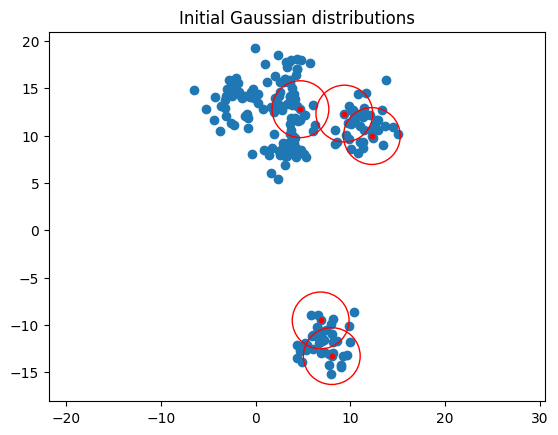

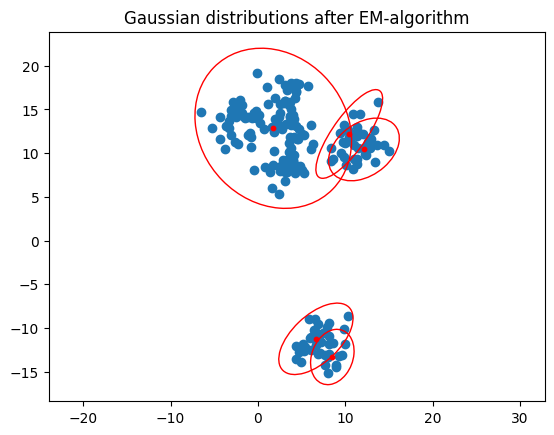

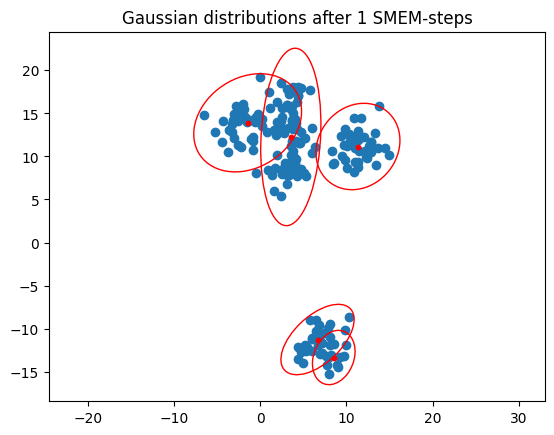

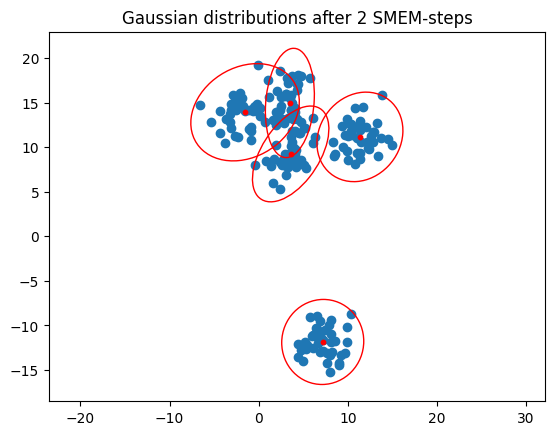

In [17]:
np.seterr(all="ignore")  # Suppress numpy warnings

N = 200
D = 2
N_cluster = 5
L = 15
plot = True

## Generation of the data
data, data_labels = generation_data(N, D, N_cluster, L, plot=plot)

## Initialization
means, covariances, densities = initialization(data, N_cluster, plot=plot)
log_likelihood_init = compute_log_likelihood(data, means, covariances, densities)

## EM algorithm
means, covariances, densities, log_likelihood_EM = expectation_maximization(
    data, means, covariances, densities, eps=1e-4, plot=plot
)

## SMEM algorithm
means, covariances, densities, log_likelihood_SMEM = split_merge_full(
    data, means, covariances, densities, eps_EM=1e-3, eps_SM=1e-3, plot=plot
)


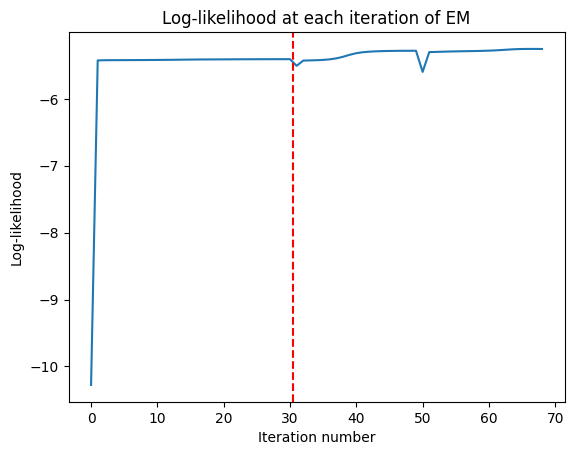

In [18]:
log_likelihood_list = [log_likelihood_init] + log_likelihood_EM + log_likelihood_SMEM

fig, ax = plt.subplots()

ax.plot(log_likelihood_list[1:])
ax.axvline(len(log_likelihood_EM) - 0.5, color='r', linestyle='--')

ax.set_title("Log-likelihood at each iteration of EM")
ax.set_xlabel("Iteration number")
ax.set_ylabel("Log-likelihood")

plt.show()


In [19]:
def find_most_likely_gaussian(data, means, covariances, densities):
    P = compute_P(data, means, covariances, densities)
    return np.argmax(P, axis=1)


def cluster_accuracy(y_true, y_pred):
    """Calculate clustering accuracy by finding the best alignment of clusters."""
    unique_labels = np.unique(y_true)
    unique_preds = np.unique(y_pred)

    cost_matrix = np.zeros((len(unique_labels), len(unique_preds)), dtype=int)
    for i, label in enumerate(unique_labels):
        for j, pred in enumerate(unique_preds):
            cost_matrix[i, j] = np.sum((y_true == label) & (y_pred == pred))

    # Find the best assignment using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)

    accuracy = cost_matrix[row_ind, col_ind].sum() / y_true.size
    return accuracy


predictions = find_most_likely_gaussian(data, means, covariances, densities)
accuracy = cluster_accuracy(data_labels, predictions)

print(f"Accuracy: {accuracy * 100}%")


Accuracy: 96.0%
